<a href="https://colab.research.google.com/github/jingwoo4710/2020_project/blob/main/Week1_project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 데이터에 관한 간단한 설명

# Big Five personality bias 문제 딜링방법

# K-means clustering 에서 equally 하게 군집이 되었는지

# 결론에 대해서 좀 더 설명


In [ ]:
## geopandas 설치
# Important library for many geopython libraries
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes 
# Install Folium for Geographic data visualization
!pip install folium
# Install plotlyExpress
!pip install plotly_express

In [2]:
# 한글 폰트
!apt-get update -qq
!apt-get install fonts-nanum* -qq

Selecting previously unselected package fonts-nanum.
(Reading database ... 144706 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-6_all.deb ...
Unpacking fonts-nanum-eco (1.000-6) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20170925-1_all.deb ...
Unpacking fonts-nanum-extra (20170925-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-1_all.deb ...
Unpacking fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-extra (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Setting up fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-eco (1.000-6) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


In [5]:
#Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr, spearmanr
import matplotlib.font_manager as fm
import matplotlib as mpl
import branca.colormap as cm
import folium
import geopandas as gpd


plt.style.use('default')
path = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'  # 설치된 나눔글꼴중 원하는 녀석의 전체 경로를 가져오자
font_name = fm.FontProperties(fname=path, size=50).get_name()
print(font_name)
plt.rc('font', family=font_name)
fm._rebuild()

NanumGothic Eco


In [95]:
# COVID19 Data Import
corona_df = pd.read_csv('WHO-COVID-19-global-data.csv')

In [96]:
# Header 확인
corona_df.head(2)

,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
0,2020-01-03,AF,Afghanistan,EMRO,0,0,0,0
1,2020-01-04,AF,Afghanistan,EMRO,0,0,0,0


In [97]:
# header 공백 제거
cols = corona_df.columns.to_list()
corona_df.columns = [element.strip() for element in cols]
corona_df.head(2)

,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
0,2020-01-03,AF,Afghanistan,EMRO,0,0,0,0
1,2020-01-04,AF,Afghanistan,EMRO,0,0,0,0


In [98]:
# 국가별 총 확진자수
df_covid = corona_df.groupby(['Country', 'Country_code'])\
                    .sum()\
                    .rename_axis(['Country', 'Country_code'])\
                    .reset_index()
df_covid = df_covid.iloc[:,:3]
df_covid.columns = ['국가', '국가코드', '확진자 수']
df_covid.head()

,국가,국가코드,확진자 수
0,Afghanistan,AF,39422
1,Albania,AL,14410
2,Algeria,DZ,52270
3,American Samoa,AS,0
4,Andorra,AD,2370


In [64]:
# Big 5 성격테스트에서 Postive 와 Negative 문제 나누기 + 필요한 열 정의
pos_questions = [
    'OPN1','OPN3','OPN5','OPN7','OPN8','OPN9','OPN10',        # 7 개방성
    'CSN1','CSN3','CSN5','CSN7','CSN9','CSN10',               # 6 성실성
    'EXT1','EXT3','EXT5','EXT7','EXT9',                       # 5 외향성
    'AGR2','AGR4','AGR6','AGR8','AGR9','AGR10',               # 6 친화성
    'EST1','EST3','EST5','EST6','EST7','EST8','EST9','EST10', # 8 안정성(신경성)
]

neg_questions = [
    'OPN2','OPN4','OPN6',                # 3 개방성
    'CSN2','CSN4','CSN6','CSN8',         # 4 성실성
    'EXT2','EXT4','EXT6','EXT8','EXT10', # 5 외향성
    'AGR1','AGR3','AGR5','AGR7',         # 4 친화성
    'EST2','EST4',                       # 2 안정성(신경성)
]

use_cols = ['country'] + pos_questions + neg_questions 

In [65]:
# Big Five Personality Test Import 
trait = pd.read_csv('data-final.csv', sep = '\t', usecols=use_cols)

In [66]:
# 값이 0인 경우 NaN 처리 + 해당 row 삭제
trait = trait.replace(0,np.NaN).dropna(axis = 0).reset_index(drop = True)

In [67]:
# Country Name이 None 인 경우 삭제
i = trait.loc[trait.country == 'NONE'].index
trait.drop(i, inplace= True)

In [68]:
trait.head()

,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,EST1,EST2,EST3,EST4,EST5,EST6,EST7,EST8,EST9,EST10,AGR1,AGR2,AGR3,AGR4,AGR5,AGR6,AGR7,AGR8,AGR9,AGR10,CSN1,CSN2,CSN3,CSN4,CSN5,CSN6,CSN7,CSN8,CSN9,CSN10,OPN1,OPN2,OPN3,OPN4,OPN5,OPN6,OPN7,OPN8,OPN9,OPN10,country
0,4.0,1.0,5.0,2.0,5.0,1.0,5.0,2.0,4.0,1.0,1.0,4.0,4.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,5.0,2.0,4.0,2.0,3.0,2.0,4.0,3.0,4.0,3.0,4.0,3.0,2.0,2.0,4.0,4.0,2.0,4.0,4.0,5.0,1.0,4.0,1.0,4.0,1.0,5.0,3.0,4.0,5.0,GB
1,3.0,5.0,3.0,4.0,3.0,3.0,2.0,5.0,1.0,5.0,2.0,3.0,4.0,1.0,3.0,1.0,2.0,1.0,3.0,1.0,1.0,4.0,1.0,5.0,1.0,5.0,3.0,4.0,5.0,3.0,3.0,2.0,5.0,3.0,3.0,1.0,3.0,3.0,5.0,3.0,1.0,2.0,4.0,2.0,3.0,1.0,4.0,2.0,5.0,3.0,MY
2,2.0,3.0,4.0,4.0,3.0,2.0,1.0,3.0,2.0,5.0,4.0,4.0,4.0,2.0,2.0,2.0,2.0,2.0,1.0,3.0,1.0,4.0,1.0,4.0,2.0,4.0,1.0,4.0,4.0,3.0,4.0,2.0,2.0,2.0,3.0,3.0,4.0,2.0,4.0,2.0,5.0,1.0,2.0,1.0,4.0,2.0,5.0,3.0,4.0,4.0,GB
3,2.0,2.0,2.0,3.0,4.0,2.0,2.0,4.0,1.0,4.0,3.0,3.0,3.0,2.0,3.0,2.0,2.0,2.0,4.0,3.0,2.0,4.0,3.0,4.0,2.0,4.0,2.0,4.0,3.0,4.0,2.0,4.0,4.0,4.0,1.0,2.0,2.0,3.0,1.0,4.0,4.0,2.0,5.0,2.0,3.0,1.0,4.0,4.0,3.0,3.0,GB
4,3.0,3.0,3.0,3.0,5.0,3.0,3.0,5.0,3.0,4.0,1.0,5.0,5.0,3.0,1.0,1.0,1.0,1.0,3.0,2.0,1.0,5.0,1.0,5.0,1.0,3.0,1.0,5.0,5.0,3.0,5.0,1.0,5.0,1.0,3.0,1.0,5.0,1.0,5.0,5.0,5.0,1.0,5.0,1.0,5.0,1.0,5.0,3.0,5.0,5.0,KE


In [105]:
# 데이터의 크기가 충분한 국가만 추출
train_countries = pd.DataFrame(data = trait.groupby('country')\
                                           .agg('size')\
                                           .loc[trait.groupby('country').agg('size') > 1000])

train_countries = train_countries.index.to_list()
print(train_countries)
len(train_countries)

['AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BR', 'CA', 'CH', 'CL', 'CN', 'CO', 'CZ', 'DE', 'DK', 'ES', 'FI', 'FR', 'GB', 'GR', 'HK', 'HR', 'HU', 'ID', 'IE', 'IL', 'IN', 'IT', 'JP', 'KE', 'KR', 'MX', 'MY', 'NL', 'NO', 'NZ', 'PE', 'PH', 'PK', 'PL', 'PT', 'RO', 'RS', 'RU', 'SE', 'SG', 'TH', 'TR', 'US', 'VN', 'ZA']


51

In [113]:
# train 데이터와 test 데이터 
train = trait.loc[trait.country.isin(train_countries)].reset_index(drop = True)
test = trait.loc[~trait.country.isin(train_countries)].reset_index(drop = True)

In [114]:
# train 국가 수 확인
print(len(train['country'].unique()))

51


In [115]:
# test 국가 수 확인
print(len(test['country'].unique()))

171


In [116]:
train.head(2)

,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,EST1,EST2,EST3,EST4,EST5,EST6,EST7,EST8,EST9,EST10,AGR1,AGR2,AGR3,AGR4,AGR5,AGR6,AGR7,AGR8,AGR9,AGR10,CSN1,CSN2,CSN3,CSN4,CSN5,CSN6,CSN7,CSN8,CSN9,CSN10,OPN1,OPN2,OPN3,OPN4,OPN5,OPN6,OPN7,OPN8,OPN9,OPN10,country
0,4.0,1.0,5.0,2.0,5.0,1.0,5.0,2.0,4.0,1.0,1.0,4.0,4.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,5.0,2.0,4.0,2.0,3.0,2.0,4.0,3.0,4.0,3.0,4.0,3.0,2.0,2.0,4.0,4.0,2.0,4.0,4.0,5.0,1.0,4.0,1.0,4.0,1.0,5.0,3.0,4.0,5.0,GB
1,3.0,5.0,3.0,4.0,3.0,3.0,2.0,5.0,1.0,5.0,2.0,3.0,4.0,1.0,3.0,1.0,2.0,1.0,3.0,1.0,1.0,4.0,1.0,5.0,1.0,5.0,3.0,4.0,5.0,3.0,3.0,2.0,5.0,3.0,3.0,1.0,3.0,3.0,5.0,3.0,1.0,2.0,4.0,2.0,3.0,1.0,4.0,2.0,5.0,3.0,MY


In [117]:
test.head(2)

,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,EST1,EST2,EST3,EST4,EST5,EST6,EST7,EST8,EST9,EST10,AGR1,AGR2,AGR3,AGR4,AGR5,AGR6,AGR7,AGR8,AGR9,AGR10,CSN1,CSN2,CSN3,CSN4,CSN5,CSN6,CSN7,CSN8,CSN9,CSN10,OPN1,OPN2,OPN3,OPN4,OPN5,OPN6,OPN7,OPN8,OPN9,OPN10,country
0,3.0,3.0,2.0,3.0,3.0,2.0,4.0,3.0,3.0,5.0,4.0,3.0,4.0,1.0,2.0,3.0,5.0,4.0,4.0,5.0,2.0,5.0,3.0,4.0,2.0,3.0,1.0,3.0,4.0,2.0,1.0,5.0,5.0,5.0,1.0,5.0,3.0,1.0,1.0,5.0,5.0,1.0,5.0,1.0,5.0,1.0,5.0,5.0,5.0,5.0,UA
1,2.0,1.0,3.0,3.0,5.0,2.0,4.0,5.0,5.0,3.0,5.0,1.0,5.0,1.0,5.0,5.0,1.0,5.0,5.0,5.0,4.0,5.0,4.0,4.0,2.0,4.0,1.0,4.0,4.0,5.0,1.0,1.0,5.0,5.0,1.0,5.0,5.0,5.0,1.0,1.0,2.0,5.0,5.0,5.0,1.0,2.0,4.0,2.0,4.0,3.0,OM


In [118]:
# test 데이터 또한 샘플이 최소 500개는 가지도록 
test_countries = test.groupby('country').size()\
                     .loc[test.groupby('country').size() > 500]\
                     .index.to_list()

test = test.loc[test.country.isin(test_countries)]
print(len(test.country.unique()))

16


In [119]:
# 평균 계산을 위해 negative question 점수 scale 바꾸기
train[neg_questions] = train[neg_questions].apply(lambda x: 6 - x)
test[neg_questions] = test[neg_questions].apply(lambda x: 6 - x)

In [208]:
df_train = train.copy()
df_test = test.copy()

In [123]:
# Fucntion 
def summing_axis (df):
  traits = ['OPN','CSN','EXT','AGR','EST']
  for trait in traits:
    df[trait] = df[[col for col in df.columns if trait in col]].sum(axis = 1)
  return df[traits+['country']]
  

In [209]:
df_train = summing_axis(df_train)
df_test = summing_axis(df_test)

In [125]:
df_train.head(2)

,OPN,CSN,EXT,AGR,EST,country
0,45.0,32.0,46.0,39.0,24.0,GB
1,35.0,37.0,20.0,44.0,25.0,MY


In [128]:
print(len(df_train.country.unique()))

51


In [129]:
print(len(df_test.country.unique()))

16


In [210]:
df_test.head(2)

,OPN,CSN,EXT,AGR,EST,country
0,50.0,24.0,29.0,37.0,39.0,UA
4,32.0,28.0,36.0,41.0,19.0,NG


In [211]:
# 나라별로 train data mean 구하기
mean_train = df_train.groupby('country').mean().rename_axis('country').reset_index()
mean_train.columns = ['국가코드', '개방성', '성실성', '외향성', '우호성', '안정성']
mean_train.head()

,국가코드,개방성,성실성,외향성,우호성,안정성
0,AE,37.639791,34.032090,30.261933,37.917770,31.475732
1,AR,40.133075,31.678530,28.345068,36.416248,32.381431
2,AT,40.836251,32.518538,29.899588,36.876931,29.856334
3,AU,38.551472,33.626061,29.937915,37.918328,30.393272
4,BE,39.308450,32.029262,29.967453,37.661989,30.598089


In [133]:
print(len(mean_train['국가코드'].unique()))

51


In [212]:
# 나라별로 test data mean 구하기
mean_test = df_test.groupby('country').mean().rename_axis('country').reset_index()
mean_test.columns = ['국가코드', '개방성', '성실성', '외향성', '우호성', '안정성']
mean_test.head()

,국가코드,개방성,성실성,외향성,우호성,안정성
0,CR,39.633028,32.664220,28.759633,35.908257,31.051376
1,EC,38.383138,31.910352,29.119530,35.337247,31.806830
2,EE,38.964045,32.362921,28.283146,35.783146,30.279775
3,EG,37.943890,33.007481,28.480050,36.966334,33.011222
4,IS,39.057728,32.614525,30.225326,37.696462,30.463687


In [135]:
print(len(mean_test['국가코드'].unique()))

16


In [213]:
# train 데이터 필터링
train_covid = df_covid.loc[df_covid['국가코드'].isin(train_countries)].reset_index(drop = True)
train_covid.head()

,국가,국가코드,확진자 수
0,Argentina,AR,798486
1,Australia,AU,27149
2,Austria,AT,49886
3,Belgium,BE,132109
4,Brazil,BR,4915289


In [136]:
print(len(train_covid['국가'].unique()))

50


In [214]:
# 빅 파이브 성격테스트와 COVID19 데이터 합치기
df_train = train_covid.merge(mean_train, on = '국가코드')
df_train.head()

,국가,국가코드,확진자 수,개방성,성실성,외향성,우호성,안정성
0,Argentina,AR,798486,40.133075,31.678530,28.345068,36.416248,32.381431
1,Australia,AU,27149,38.551472,33.626061,29.937915,37.918328,30.393272
2,Austria,AT,49886,40.836251,32.518538,29.899588,36.876931,29.856334
3,Belgium,BE,132109,39.308450,32.029262,29.967453,37.661989,30.598089
4,Brazil,BR,4915289,40.536946,31.240467,26.505017,34.946725,31.545703


In [215]:
len(df_train)

50

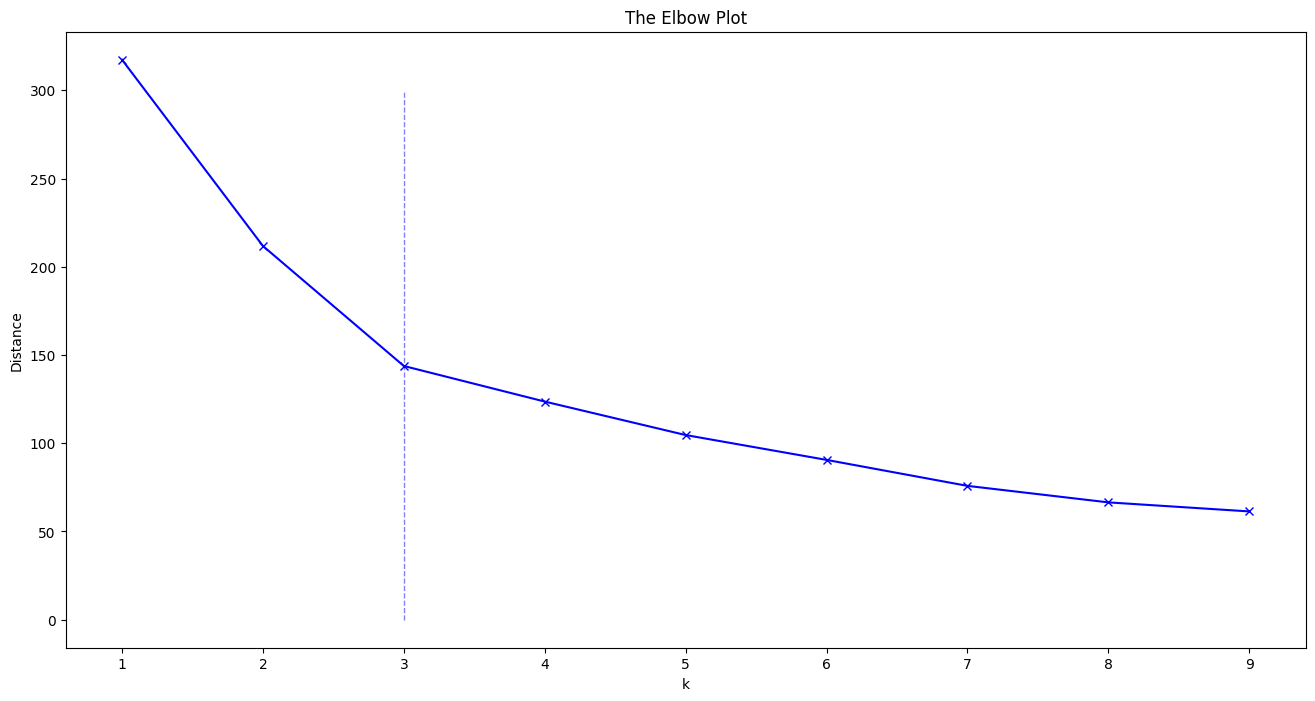

In [216]:
# elbow plot
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df_train.iloc[:,3:8])
    distortions.append(kmeanModel.inertia_)
   

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distance')
plt.title('The Elbow Plot')
plt.vlines(x=3, ymin=0, ymax=300, alpha=0.5, color='blue', linestyle='dashed', linewidth=1.0)
plt.show()

In [217]:
#k = 2로 설정
kmeans = KMeans(n_clusters=2)
kmeans.fit(df_train.iloc[:,3:8])
df_train['군집'] = kmeans.labels_
df_train.head()

,국가,국가코드,확진자 수,개방성,성실성,외향성,우호성,안정성,군집
0,Argentina,AR,798486,40.133075,31.678530,28.345068,36.416248,32.381431,1
1,Australia,AU,27149,38.551472,33.626061,29.937915,37.918328,30.393272,0
2,Austria,AT,49886,40.836251,32.518538,29.899588,36.876931,29.856334,0
3,Belgium,BE,132109,39.308450,32.029262,29.967453,37.661989,30.598089,0
4,Brazil,BR,4915289,40.536946,31.240467,26.505017,34.946725,31.545703,1


In [218]:
# label별 case 확인
print('군집 0의 수 : ', len(df_train.loc[df_train['군집'] == 0]))
print('군집 1의 수 : ', len(df_train.loc[df_train['군집'] == 1]))

군집 0의 수 :  26
군집 1의 수 :  24


In [219]:
# 결과가 좋지 않음 지나치게 outlier 인 미국과 인도를 빼자
i = df_train.loc[(df_train['국가'] == 'India') | (df_train['국가'] == 'United States of America')].index
df_train.drop(i, inplace=True)

In [227]:
# Label 별로 그룹
traits = ['개방성','성실성','외향성','우호성','안정성']

train_res = df_train.iloc[:, 2:]\
                    .groupby('군집')\
                    .mean()\
                    .rename_axis('군집')\
                    .reset_index()
train_res = train_res.apply(lambda x: x.round(2))
train_res = train_res.sort_values('확진자 수', ascending=False).reset_index(drop=True)
train_res

,군집,확진자 수,개방성,성실성,외향성,우호성,안정성
0,1,512379.08,39.65,32.13,28.48,35.84,31.62
1,0,168060.58,38.62,33.39,29.80,37.43,30.49


In [221]:
# test 나라들의 데이터 예측
mean_test['군집'] = kmeans.predict(mean_test.iloc[:,1:])
mean_test.head()

,국가코드,개방성,성실성,외향성,우호성,안정성,군집
0,CR,39.633028,32.664220,28.759633,35.908257,31.051376,1
1,EC,38.383138,31.910352,29.119530,35.337247,31.806830,1
2,EE,38.964045,32.362921,28.283146,35.783146,30.279775,1
3,EG,37.943890,33.007481,28.480050,36.966334,33.011222,1
4,IS,39.057728,32.614525,30.225326,37.696462,30.463687,0


In [225]:
df_test.head(2)

,국가코드,개방성,성실성,외향성,우호성,안정성,군집,국가,확진자 수
0,CR,39.633028,32.664220,28.759633,35.908257,31.051376,1,Costa Rica,79182
1,EC,38.383138,31.910352,29.119530,35.337247,31.806830,1,Ecuador,141339


In [228]:
# Label 별로 그룹
df_test = mean_test.merge(df_covid, on = '국가코드')


test_res = df_test.loc[:, ['군집', '확진자 수'] + traits]\
                    .groupby('군집')\
                    .mean()\
                    .rename_axis('군집')\
                    .reset_index()
test_res = test_res.apply(lambda x: x.round(2))
test_res = test_res.sort_values('확진자 수', ascending=False).reset_index(drop=True)
test_res

,군집,확진자 수,개방성,성실성,외향성,우호성,안정성
0,1,100305.4,39.24,32.40,28.40,35.64,31.53
1,0,32628.0,38.57,34.19,29.64,37.93,30.71


In [263]:
train_res.iloc[0,1]/train_res.iloc[1,1]

3.04877610204606

In [264]:
test_res.iloc[0,1]/test_res.iloc[1,1]

3.074212332965551

In [ ]:
# Plot

In [241]:
final_df = pd.concat([train_res, test_res], axis = 0)

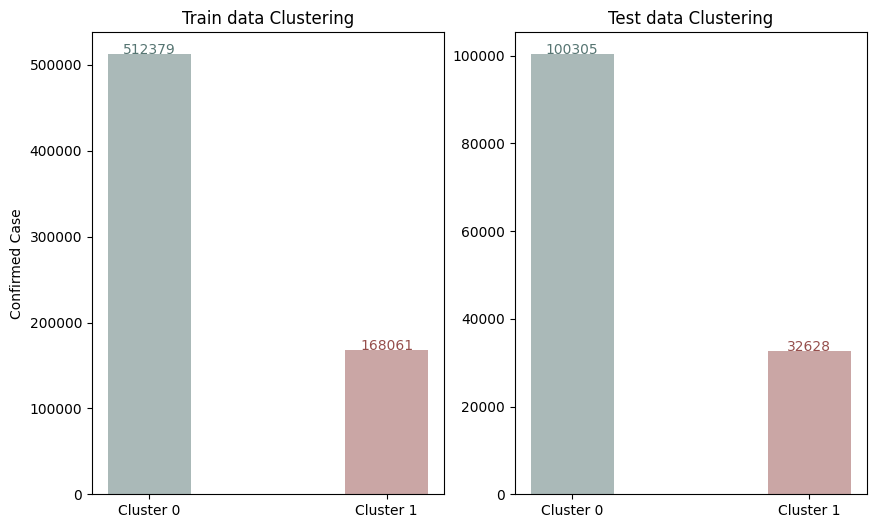

In [289]:
fig, axes = plt.subplots(1,2, figsize=(10, 6))

bar_width = 0.35

alpha = 0.5

index = np.arange(2)

y1 = train_res['확진자 수']

y2 = test_res['확진자 수']

p1 = axes[0].bar(index, y1, 

             bar_width, 

             color=['#567572FF', '#964F4CFF'],

             alpha=alpha,

             label='Train')
axes[0].set_xticks(index)
axes[0].set_xticklabels(['Cluster 0', 'Cluster 1'])
axes[0].set_ylabel('Confirmed Case')

axes[0].set_title('Train data Clustering')

p2 = axes[1].bar(index, y2, 

             bar_width, 

             color=['#567572FF', '#964F4CFF'], 

             alpha=alpha,

             label='Test')


axes[1].set_xticks(index)
axes[1].set_xticklabels(['Cluster 0', 'Cluster 1'])

axes[0].annotate(str(int(round(y1[0], 0))), xy=(0, y1[0]), fontsize=10, ha='center', color = '#567572FF') 
axes[0].annotate(str(int(round(y1[1], 0))), xy=(1, y1[1]), fontsize=10, ha='center', color = '#964F4CFF') 
axes[1].annotate(str(int(round(y2[0], 0))), xy=(0, y2[0]), fontsize=10, ha='center', color = '#567572FF') 
axes[1].annotate(str(int(round(y2[1], 0))), xy=(1, y2[1]), fontsize=10, ha='center', color = '#964F4CFF') 

plt.title('Test data Clustering')

plt.show()




In [155]:
# Geometry
countries = gpd.read_file('99bfd9e7-bb42-4728-87b5-07f8c8ac631c2020328-1-1vef4ev.lu5nk.shp')

In [195]:
countries.head(2)

,OBJECTID,Country,geometry
0,1,Aruba,"POLYGON ((-69.88223 12.41111, -69.94695 12.436..."
1,2,Antigua and Barbuda,"MULTIPOLYGON (((-61.73889 17.54055, -61.75195 ..."


In [157]:
corona_df.head(2)

,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
0,2020-01-03,AF,Afghanistan,EMRO,0,0,0,0
1,2020-01-04,AF,Afghanistan,EMRO,0,0,0,0


In [158]:
# 열 이름 통일
countries = countries.rename(columns={'CNTRY_NAME': 'Country'})

In [159]:
# 코로나바이러스 데이터와, geometry 데이터와의 나라 이름 통일

corona_df = corona_df.replace({'Country' : 'Republic of Korea'}, 'South Korea')

corona_df = corona_df.replace({'Country' : 'United States of America'}, 'United States')

corona_df = corona_df.replace({'Country' : 'Venezuela (Bolivarian Republic of)'}, 'Venezuela')

corona_df = corona_df.replace({'Country' : 'Bolivia (Plurinational State of)'}, 'Bolivia')

corona_df = corona_df.replace({'Country' : 'Russian Federation'}, 'Russia')

corona_df = corona_df.replace({'Country' : 'Iran (Islamic Republic of)'}, 'Iran')

corona_df = corona_df.replace({'Country' : 'Viet Nam'}, 'Vietnam')

corona_df = corona_df.replace({'Country' : "Lao People's Democratic Republic"}, 'Laos')

corona_df = corona_df.replace({'Country' : "Syrian Arab Republic"}, 'Syria')

corona_df = corona_df.replace({'Country' : "United Republic of Tanzania"}, 'Tanzania')

corona_df = corona_df.replace({'Country' : "Democratic Republic of the Congo"}, 'Congo')

corona_df = corona_df.replace({'Country' : 
                      dict.fromkeys(['Mainland China', 
                                     'Hong Kong', 
                                     'Macau'], 
                                     'China')})
corona_df = corona_df.replace({'Country' : 'The United Kingdom'}, 
                                'United Kingdom')
corona_df = corona_df.replace({'Country' : 'North Ireland'}, 
                                'United Kingdom')
corona_df = corona_df.replace({'Country' : 'Republic of Ireland'}, 
                                'Ireland')
corona_df = corona_df.replace({'Country' : 'Vatican City'}, 
                                'Italy')
countries = countries.replace({'Country' : 'Byelarus'}, 
                               'Belarus')
countries = countries.replace({'Country' : 'Macedonia'}, 
                               'North Macedonia')
countries = countries.replace({'Country' : 'Myanmar (Burma)'}, 
                               'Myanmar')
countries = countries.replace({'Country' : 'Tanzania, United Republic of'}, 
                               'Tanzania')

In [160]:
# 확진자가 0인경우 drop
corona_df = corona_df[corona_df.New_cases != 0]

In [161]:
sorted_df = corona_df.sort_values(['Country', 
                     'Date_reported']).reset_index(drop=True)
sorted_df.head(2)                     

,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
0,2020-02-24,AF,Afghanistan,EMRO,5,5,0,0
1,2020-03-07,AF,Afghanistan,EMRO,3,8,0,0


In [162]:
sum_df = sorted_df.groupby(['Country', 'Date_reported'], as_index=False).sum()
sum_df.head()

,Country,Date_reported,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
0,Afghanistan,2020-02-24,5,5,0,0
1,Afghanistan,2020-03-07,3,8,0,0
2,Afghanistan,2020-03-11,3,11,0,0
3,Afghanistan,2020-03-14,3,14,0,0
4,Afghanistan,2020-03-15,6,20,0,0


In [163]:
joined_df = sum_df.merge(countries, on='Country')
joined_df.head(2)

,Country,Date_reported,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths,OBJECTID,geometry
0,Afghanistan,2020-02-24,5,5,0,0,3,"POLYGON ((61.27656 35.60725, 61.29638 35.62853..."
1,Afghanistan,2020-03-07,3,8,0,0,3,"POLYGON ((61.27656 35.60725, 61.29638 35.62853..."


In [164]:
joined_df['log_Confirmed'] = np.log10(joined_df['New_cases'])

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [165]:
joined_df['date_sec'] = pd.to_datetime(joined_df['Date_reported']).astype(int) / 10**9
joined_df['date_sec'] = joined_df['date_sec'].astype(int).astype(str)

In [166]:
joined_df.head(2)

,Country,Date_reported,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths,OBJECTID,geometry,log_Confirmed,date_sec
0,Afghanistan,2020-02-24,5,5,0,0,3,"POLYGON ((61.27656 35.60725, 61.29638 35.62853...",0.698970,1582502400
1,Afghanistan,2020-03-07,3,8,0,0,3,"POLYGON ((61.27656 35.60725, 61.29638 35.62853...",0.477121,1583539200


In [167]:
joined_df = joined_df[['Country', 'date_sec', 'log_Confirmed', 'geometry']]
joined_df.head(2)

,Country,date_sec,log_Confirmed,geometry
0,Afghanistan,1582502400,0.698970,"POLYGON ((61.27656 35.60725, 61.29638 35.62853..."
1,Afghanistan,1583539200,0.477121,"POLYGON ((61.27656 35.60725, 61.29638 35.62853..."


In [168]:
joined_df = joined_df.dropna()

In [169]:
max_colour = max(joined_df['log_Confirmed'])
min_colour = min(joined_df['log_Confirmed'])
cmap = cm.linear.YlOrRd_09.scale(min_colour, max_colour)
cmap
joined_df['colour'] = joined_df['log_Confirmed'].map(cmap)

In [170]:
country_list = joined_df['Country'].unique().tolist()
country_idx = range(len(country_list))

style_dict = {}
for i in country_idx:
    country = country_list[i]
    result = joined_df[joined_df['Country'] == country]
    inner_dict = {}
    for _, r in result.iterrows():
        inner_dict[r['date_sec']] = {'color': r['colour'], 'opacity': 0.7}
    style_dict[str(i)] = inner_dict

In [171]:
countries_df = joined_df[['geometry']]
countries_gdf = gpd.GeoDataFrame(countries_df)
countries_gdf = countries_gdf.drop_duplicates().reset_index()

In [172]:
from folium.plugins import TimeSliderChoropleth

slider_map = folium.Map(min_zoom=2, max_bounds=True,tiles='cartodbpositron')

_ = TimeSliderChoropleth(
    data=countries_gdf.to_json(),
    styledict=style_dict,

).add_to(slider_map)

_ = cmap.add_to(slider_map)
cmap.caption = "Log of number of confirmed cases"
slider_map.save(outfile='Whole_Country.html')

In [174]:
# Country Code
code = pd.read_csv('wikipedia-iso-country-codes.csv', usecols=['English short name lower case', 'Alpha-2 code'])
code.columns = ['국가', '국가코드']
code.head(2)

,국가,국가코드
0,Afghanistan,AF
1,Åland Islands,AX


In [175]:
# Country 이름
mean_test = mean_test.merge(code, on = '국가코드')

In [177]:
mean_test.loc[mean_test['군집'] == 0]

,국가코드,개방성,성실성,외향성,우호성,안정성,군집,국가
4,IS,39.057728,32.614525,30.225326,37.696462,30.463687,0,Iceland
5,LB,38.235465,34.341570,30.559593,37.918605,31.257267,0,Lebanon
6,LK,36.939114,34.247232,30.289668,37.566421,31.051661,0,Sri Lanka
8,NG,39.150721,36.436435,28.460026,39.263434,29.598952,0,Nigeria
9,PR,39.487078,33.304175,28.642147,37.194831,31.163022,0,Puerto Rico
13,TW,37.929382,32.440101,29.620429,37.263556,30.815889,0,Taiwan


In [186]:
# 확진자수가 가장많은 분류군
many_countries = mean_test.loc[mean_test['군집'] == train_res.iloc[0, 0]]['국가'].unique().tolist()
df_many = joined_df.loc[joined_df.Country.isin(many_countries)].reset_index(drop=True)
df_many.head(2)

,Country,date_sec,log_Confirmed,geometry,colour
0,Costa Rica,1583625600,0.954243,"POLYGON ((-82.93047 9.06312, -82.88223 9.06722...",#ffe38aff
1,Costa Rica,1583712000,0.602060,"POLYGON ((-82.93047 9.06312, -82.88223 9.06722...",#ffeea2ff


In [187]:
print(many_countries)

['Costa Rica', 'Ecuador', 'Estonia', 'Egypt', 'Lithuania', 'Saudi Arabia', 'Slovenia', 'Slovakia', 'Ukraine', 'Venezuela']


In [188]:
max_colour = max(joined_df['log_Confirmed'])
min_colour = min(joined_df['log_Confirmed'])
cmap = cm.linear.YlOrRd_09.scale(min_colour, max_colour)
cmap
df_many['colour'] = df_many['log_Confirmed'].map(cmap)

In [189]:
country_list = df_many['Country'].unique().tolist()
country_idx = range(len(country_list))

style_dict = {}
for i in country_idx:
    country = country_list[i]
    result = joined_df[joined_df['Country'] == country]
    inner_dict = {}
    for _, r in result.iterrows():
        inner_dict[r['date_sec']] = {'color': r['colour'], 'opacity': 0.7}
    style_dict[str(i)] = inner_dict

In [190]:
countries_df = df_many[['geometry']]
countries_gdf = gpd.GeoDataFrame(countries_df)
countries_gdf = countries_gdf.drop_duplicates().reset_index()

In [191]:
from folium.plugins import TimeSliderChoropleth

slider_map = folium.Map(min_zoom=2, max_bounds=True,tiles='cartodbpositron')

_ = TimeSliderChoropleth(
    data=countries_gdf.to_json(),
    styledict=style_dict,

).add_to(slider_map)

_ = cmap.add_to(slider_map)
cmap.caption = "Log of number of confirmed cases"
slider_map.save(outfile='Many.html')

In [192]:
# 확진자수가 적은 분류군
less_countries = mean_test.loc[mean_test['군집'] == train_res.iloc[1, 0]]['국가'].unique().tolist()
df_less = joined_df.loc[joined_df.Country.isin(less_countries)].reset_index(drop=True)
df_less.head(2)


,Country,date_sec,log_Confirmed,geometry,colour
0,Iceland,1583020800,0.778151,"POLYGON ((-22.02472 64.41888, -22.02444 64.443...",#ffe896ff
1,Iceland,1583107200,0.845098,"POLYGON ((-22.02472 64.41888, -22.02444 64.443...",#ffe691ff


In [193]:
max_colour = max(joined_df['log_Confirmed'])
min_colour = min(joined_df['log_Confirmed'])
cmap = cm.linear.YlOrRd_09.scale(min_colour, max_colour)
cmap
df_less['colour'] = df_less['log_Confirmed'].map(cmap)
country_list = df_less['Country'].unique().tolist()
country_idx = range(len(country_list))

style_dict = {}
for i in country_idx:
    country = country_list[i]
    result = joined_df[joined_df['Country'] == country]
    inner_dict = {}
    for _, r in result.iterrows():
        inner_dict[r['date_sec']] = {'color': r['colour'], 'opacity': 0.7}
    style_dict[str(i)] = inner_dict

In [194]:
countries_df = df_less[['geometry']]
countries_gdf = gpd.GeoDataFrame(countries_df)
countries_gdf = countries_gdf.drop_duplicates().reset_index()
from folium.plugins import TimeSliderChoropleth

slider_map = folium.Map(min_zoom=2, max_bounds=True,tiles='cartodbpositron')

_ = TimeSliderChoropleth(
    data=countries_gdf.to_json(),
    styledict=style_dict,

).add_to(slider_map)

_ = cmap.add_to(slider_map)
cmap.caption = "Log of number of confirmed cases"
slider_map.save(outfile='Less.html')

NameError: ignored

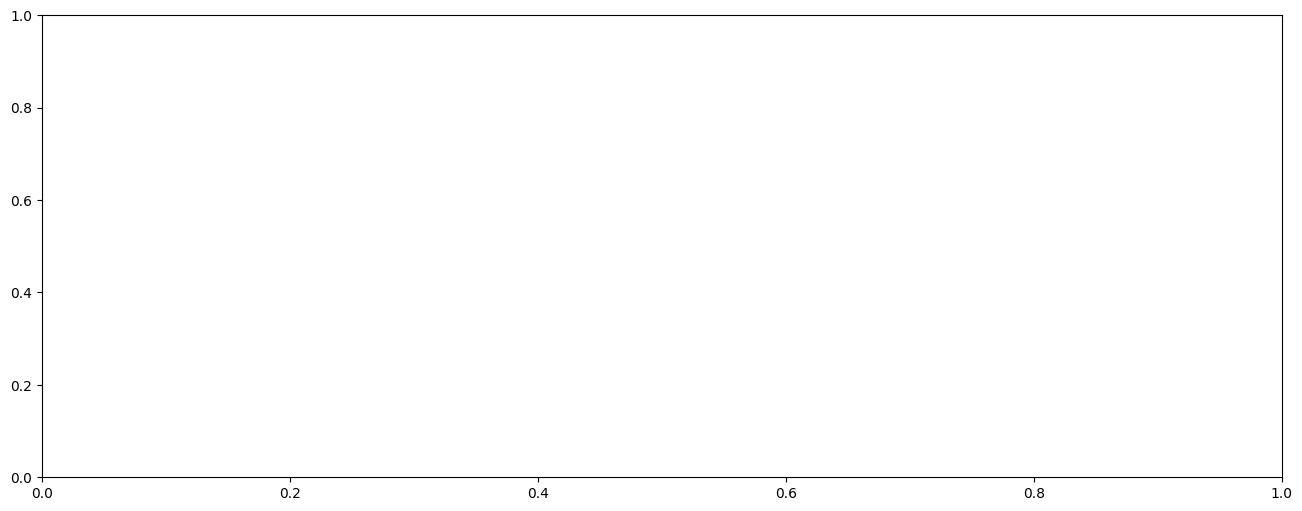

In [ ]:
# 한국 성격테스트 결과
fig, ax = plt.subplots(figsize=(16, 6))
traits = {
    'OPN': '개방성',
    'CSN': '성실성',
    'EXT': '외향성',
    'AGR': '친화성',
    'EST': '안정성'
}

mean_OPN = np.mean(df_traits[df_traits['country'] == 'KR']['OPN'])
mean_AGR = np.mean(df_traits[df_traits['country'] == 'KR']['AGR'])                  

for trait in traits.keys():
  if trait in ['OPN']:
    sns.distplot(df_traits[df_traits['country'] == 'KR'][trait], bins=40, axlabel=False, hist = False, color = '#00A4CCFF')
  elif trait in ['AGR']:
    sns.distplot(df_traits[df_traits['country'] == 'KR'][trait], bins=40, axlabel=False, hist = False, color = '#F95700FF')
  else:
    sns.distplot(df_traits[df_traits['country'] == 'KR'][trait], bins=40, axlabel=False, hist = False, color='dimgray')

plt.vlines(x=mean_OPN, ymin = 0, ymax=0.06, colors='#00A4CCFF', linestyles='dashed')   

plt.vlines(x=mean_AGR, ymin = 0, ymax=0.06, colors='#F95700FF', linestyles='dashed')   

for spine in ax.spines.values():
    spine.set_visible(False)

plt.annotate('개방성  '+ str(round(mean_OPN, 2)), xy=(mean_OPN, 0.06), xytext = (mean_OPN+3, 0.06), fontsize=14, ha='center', color = '#00A4CCFF') 
plt.annotate( str(round(mean_AGR, 2)) + '  우호성', xy=(mean_AGR, 0.06), xytext = (mean_AGR-3, 0.06), fontsize=14, ha='center', color = '#F95700FF')  

plt.title('한국인의 성격 테스트 결과', loc='left', fontsize = 15)

plt.ylabel("")